# BIO_52101_EP: Cell shapes project

## Import all the necessary libraries

In [1]:
import omero
from omero.gateway import BlitzGateway

import matplotlib.pyplot as plt
import numpy as np
import re

from pandas import DataFrame, read_hdf

## Sample some of the images

In [2]:
def connect(hostname, username, password):
    conn = BlitzGateway(username, password,
                        host=hostname, secure=True)
    print("Connected: %s" % conn.connect())
    conn.c.enableKeepAlive(60)
    return conn

In [3]:
#### Code form the class ####
def getBulkAnnotationAsDf(screenID, conn):
    import re

    ofId = None
    sc = conn.getObject('Screen', screenID)
    for ann in sc.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            if (ann.getFile().getName() == 'bulk_annotations'):
                if (ann.getFile().getSize()> 1476250900): #about 140Mb?
                    print("that's a big file...")
                    return None
                ofId = ann.getFile().getId()
                break

    if ofId is None:
        return None

    original_file = omero.model.OriginalFileI(ofId, False)

    table = conn.c.sf.sharedResources().openTable(original_file)
    count = 0
    try:
        rowCount = table.getNumberOfRows()

        column_names = []
        pattern = re.compile("Phenotype \d+$")
        for col in table.getHeaders():
            column_names.append(col.name)
            if pattern.match(col.name) is not None:
                count = count + 1

        black_list = []
        column_indices = []
        for column_name in column_names:
            if column_name in black_list:
                continue
            column_indices.append(column_names.index(column_name))

        table_data = table.slice(column_indices, None)
    finally:
        table.close()

    data = []
    for index in range(rowCount):
        row_values = [column.values[index] for column in table_data.columns]
        data.append(row_values)

    dfAnn = DataFrame(data)
    dfAnn.columns = column_names
    return dfAnn, count

<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:27: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2237373/2022752706.py:27: SyntaxWarning: invalid escape sequence '\d'
  pattern = re.compile("Phenotype \d+$")


In [4]:
host = "ws://idr.openmicroscopy.org/omero-ws"
username = "public"
password = "public"
screenId = 1751 #idr0033-rohban-pathways/screenA

# Connect to the server
conn = connect(host, username, password)

# Downloading the annotation file for the whole screen
# as a panda DataFrame
dfAnn, phenotype_count = getBulkAnnotationAsDf(screenId, conn)


Connected: True


In [5]:
dfAnn.head()

,Plate,Well,Well Number,Characteristics [Organism],Term Source 1 REF,Term Source 1 Accession,Characteristics [Cell Line],Term Source 2 REF,Term Source 2 Accession,ORF Identifier,...,Phenotype 19,Phenotype 20,Phenotype 20 Term Name,Phenotype 20 Term Accession,Phenotype 21,Phenotype 21 Term Name,Phenotype 21 Term Accession,Phenotype 22,Plate Name,Well Name
0,5958,1312840,1,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,,...,,,,,,,,,41744,a1
1,5958,1312474,2,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,,...,,,,,,,,,41744,a2
2,5958,1312523,3,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,ccsbBroad304_00117,...,,,,,low cell density,decreased cell numbers,CMPO_0000052,,41744,a3
3,5958,1312835,4,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,ccsbBroad304_07101,...,,,,,,,,,41744,a4
4,5958,1312626,5,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,ccsbBroad304_00150,...,,,,,,,,,41744,a5


1312474


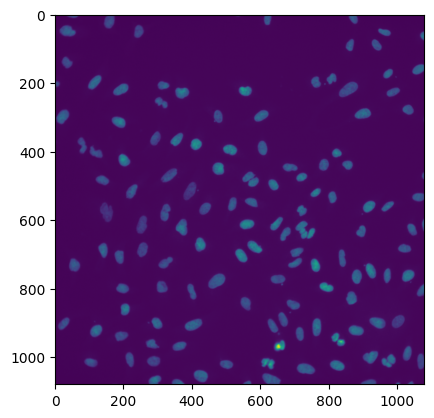

In [16]:
weid=dfAnn.Well[1]
print(weid)
we = conn.getObject('Well', weid)
ImO = we.getImage(8).getPrimaryPixels().getPlane(0,0,0)
# display image
imgplot = plt.imshow(ImO)
plt.show()

## Load the data

In [7]:
dfAnn=read_hdf('./annotationsIdr0033.hdf', align=0)
dfAnn.columns

/users/eleves-b/2025/daniela.cojocaru/miniconda3/envs/BIO/lib/python3.12/site-packages/tables/atom.py:1374: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  return pickle.loads(array.tobytes())


Index(['Plate', 'Well', 'Well Number', 'Characteristics [Organism]',
       'Term Source 1 REF', 'Term Source 1 Accession',
       'Characteristics [Cell Line]', 'Term Source 2 REF',
       'Term Source 2 Accession', 'ORF Identifier', 'ORF Sequence',
       'ORF Comments', 'Target Transcript', 'Gene Allele Name',
       'Reagent Design Gene Annotation Build', 'Gene Identifier',
       'Gene Symbol', 'Analysis Gene Annotation Build',
       'Gene Annotation Comments', 'Control Type', 'Control Comments',
       'Quality Control', 'Quality Control Comments', 'Channels', 'Comments',
       'Median Replicate Correlation', 'Morphological Cluster ID',
       'Has Phenotype', 'Phenotype Annotation Level', 'Phenotype 1',
       'Phenotype 1 Term Name', 'Phenotype 1 Term Accession', 'Phenotype 2',
       'Phenotype 2 Term Name', 'Phenotype 2 Term Accession', 'Phenotype 3',
       'Phenotype 3 Term Name', 'Phenotype 3 Term Accession', 'Phenotype 4',
       'Phenotype 4 Term Name', 'Phenotype 4 Te

In [23]:
dfAnn[:390]

,Plate,Well,Well Number,Characteristics [Organism],Term Source 1 REF,Term Source 1 Accession,Characteristics [Cell Line],Term Source 2 REF,Term Source 2 Accession,ORF Identifier,...,Phenotype 19,Phenotype 20,Phenotype 20 Term Name,Phenotype 20 Term Accession,Phenotype 21,Phenotype 21 Term Name,Phenotype 21 Term Accession,Phenotype 22,Plate Name,Well Name
0,5958,1312840,1,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,,...,,,,,,,,,41744,a1
1,5958,1312474,2,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,,...,,,,,,,,,41744,a2
2,5958,1312523,3,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,ccsbBroad304_00117,...,,,,,low cell density,decreased cell numbers,CMPO_0000052,,41744,a3
3,5958,1312835,4,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,ccsbBroad304_07101,...,,,,,,,,,41744,a4
4,5958,1312626,5,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,ccsbBroad304_00150,...,,,,,,,,,41744,a5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,5960,1313129,2,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,,...,,,,,,,,,41749,a2
386,5960,1313236,3,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,ccsbBroad304_00117,...,,,,,low cell density,decreased cell numbers,CMPO_0000052,,41749,a3
387,5960,1313185,4,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,ccsbBroad304_07101,...,,,,,,,,,41749,a4
388,5960,1313434,5,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,ccsbBroad304_00150,...,,,,,,,,,41749,a5


In [9]:
dfAnn[['Well Number']].value_counts()

Well Number
1              12
10             12
100            12
101            12
102            12
               ..
95             12
96             12
97             12
98             12
99             12
Name: count, Length: 384, dtype: int64

## Group the data by phenotype

We want to separate the rows that have each phenotype (there is text in the column respective to Phenotype n) and extract the wells that are represented in this subset.

In [17]:
phenotype_count=22
wells = []
for i in range(1, phenotype_count+1):
     wells.append(dfAnn[dfAnn[f'Phenotype {i}'] != '']['Well'].unique())

wells

[array([1312523, 1312822, 1312461, 1312706, 1312580, 1312813, 1312524,
        1312460, 1312691, 1312608, 1312789, 1312796, 1312562, 1312662,
        1313236, 1313242, 1313208, 1313153, 1313397, 1313445, 1313214,
        1313403, 1313161, 1313138, 1313432, 1313146, 1313176, 1313346,
        1313911, 1313823, 1313630, 1313561, 1313698, 1313612, 1313552,
        1313781, 1313894, 1313757, 1313615, 1313742, 1313909, 1313797,
        1314266, 1313932, 1314026, 1313949, 1314273, 1314210, 1313971,
        1314249, 1314214, 1313942, 1314035, 1314056, 1314105, 1314129,
        1314857, 1314934, 1314781, 1314796, 1314761, 1314936, 1314963,
        1314864, 1314748, 1314717, 1314834, 1314812, 1314767, 1314745,
        1315324, 1315112, 1315371, 1315373, 1315312, 1315348, 1315148,
        1315284, 1315017, 1315044, 1315089, 1315211, 1315165, 1315266,
        1315508, 1315532, 1315539, 1315379, 1315442, 1315658, 1315527,
        1315689, 1315440, 1315696, 1315713, 1315759, 1315722, 1315737,
      

## Analyse the images for each group

In [24]:
for i in range(1, phenotype_count+1):
    we = conn.getObject('Well', wells[i-1][0])
    ImO = we.getImage(8).getPrimaryPixels().getPlane(0,0,0)

In [11]:
### Segmentation

In [12]:
### Identify the average per image

In [13]:
### Generalize for the phenotype group

## Inhterpret results